In [2]:
# 모듈 불러오기
from collections import Counter

import nltk
nltk.download('punkt')
from nltk import word_tokenize
import itertools

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, LSTM
from tensorflow.keras.layers import Dot, Add, Permute, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"
train_path = f"{data_path}/qa1_single-supporting-fact_train.txt"
test_path = f"{data_path}/qa1_single-supporting-fact_test.txt"

# _1_. 데이터 불러 오기 및 확인

* 데이터 생김새

```
1 Sandra went back to the bedroom.

2 Sandra went to the garden.

3 Where is Sandra? 	garden	2

4 Daniel travelled to the bathroom.

5 Mary moved to the garden.

6 Where is Mary? 	garden	5

7 Mary went back to the bathroom.

8 John moved to the kitchen.

9 Where is John? 	kitchen	8

10 Mary went to the kitchen.

11 John travelled to the office.

12 Where is Mary? 	kitchen	10

13 Mary went to the bedroom.

14 Mary travelled to the bathroom.

15 Where is Mary? 	bathroom	14
```

* 공백 기준 1번 분할해서 line number와 text로 나눈다.

```
['1', 'Sandra went back to the office.\n']
['2', 'Mary went back to the bathroom.\n']
['3', 'Where is Sandra? \toffice\t1\n']
['4', 'Sandra went back to the bathroom.\n']
['5', 'Daniel travelled to the garden.\n']
['6', 'Where is Sandra? \tbathroom\t4\n']
['7', 'Mary went back to the garden.\n']
['8', 'Sandra went back to the office.\n']
['9', 'Where is Sandra? \toffice\t8\n']
['10', 'Mary moved to the hallway.\n']
['11', 'Daniel journeyed to the bedroom.\n']
['12', 'Where is Mary? \thallway\t10\n']
['13', 'Daniel travelled to the bathroom.\n']
['14', 'John journeyed to the bathroom.\n']
['15', 'Where is Daniel? \tbathroom\t13\n']
```

    - 나눈 거 안에 `\t`이 있으면 question, answer이란 소리
    - `\t` 기준 나눴을 때 question, answer, 정답이 있는 번호로 나뉜다.

* `\t`이 나와서 question, answer 문장까지 나왔으면 그 앞에 두 문장은 story란 의미이므로, stories에 더해 주고, story_text를 초기화한다.

* stories, questions, answers를 반환하는 함수가 계속 그대로 가므로, 앞으로 데이터를 변수에 할당할 때도 묶음으로!

In [4]:
# 데이터 가져오는 함수
def get_data(inFile):
    stories, questions, answers = [], [], []
    story_text = []

    with open(inFile, "r") as f:
        for line in f:
            lno, text = line.split(sep=" ", maxsplit=1) # 두 개로 나눔.

            if "\t" in text: # tab으로 구분되어서 마지막까지 왔다는 의미
                # question, answer 추가
                question, answer, _ = text.split("\t") # 정답 문장 번호는 _
                questions.append(question)
                answers.append(answer)

                # story 추가 및 초기화
                stories.append(story_text) # story text 더해 주고 초기화
                story_text = []

            else: # 마지막 question answer 문장이 아니라는 의미
                story_text.append(text)
    
    return stories, questions, answers            

In [5]:
# 데이터 가져 오기
train_data = get_data(train_path)
test_data = get_data(test_path)
print(f"Train Observations: {len(train_data[0])}, Test Observations: {len(test_data[0])}")

Train Observations: 10000, Test Observations: 1000


# _2_. 어휘집(Vocabulary) 생성

- `train_data`와 `test_data`에 있는 각각의 stories, questions, answers를 한 번에 묶는다.
- Counter 통해 어휘집 만들면, 그 안에 튜플 형태로 단어와 단어의 등장 빈도가 들어 있다.
- 어휘집 생성 시, Padding 단어를 사용하기 위해 인덱스를 한 칸씩 밀어 주고, 0번을 padding으로 사용한다.

In [6]:
vocab_dict = Counter()

for stories, questions, answers in [train_data, test_data]:

    # story 안의 단어 추가
    for story in stories:
        for sentence in story:
            for word in word_tokenize(sentence):
                vocab_dict[word.lower()] += 1
    
    # question 안의 단어 추가
    for question in questions:
        for word in word_tokenize(question):
            vocab_dict[word.lower()] += 1
    
    # answer 안의 단어 추가
    for answer in answers:
        for word in word_tokenize(answer):
            vocab_dict[word.lower()] += 1

In [7]:
# 어휘집 생성
word2idx = {w:(i+1) for i, (w, _) in enumerate(vocab_dict.most_common())}
word2idx['PAD'] = 0
idx2word = {w:i for i, w in word2idx.items()}

In [8]:
# 어휘집합 크기 설정
vocab_size = len(word2idx)
print(f"Vocabulary Size: {vocab_size}")
print(word2idx)

Vocabulary Size: 22
{'to': 1, 'the': 2, '.': 3, 'where': 4, 'is': 5, '?': 6, 'went': 7, 'john': 8, 'sandra': 9, 'mary': 10, 'daniel': 11, 'bathroom': 12, 'office': 13, 'garden': 14, 'hallway': 15, 'kitchen': 16, 'bedroom': 17, 'journeyed': 18, 'travelled': 19, 'back': 20, 'moved': 21, 'PAD': 0}


# _3_. 문장 최대 길이 설정

- input module, question module 각각에서 패딩을 위해 설정한다

In [9]:
# input sequence 최대 길이 계산
story_maxlen = 0

for stories, questions, answers in [train_data, test_data]:
    for story in stories:
        # 각 스토리별로 초기화
        story_len = 0
        for sent in story:
            story_words = word_tokenize(sent)
            story_len += len(story_words)
        
        # 최대값보다 크면 업데이트
        if story_len > story_maxlen:
            story_maxlen = story_len

In [10]:
# question sequence 최대 길이 계산
question_maxlen = 0

for stories, questions, answers in [train_data, test_data]:
    for question in questions:
        question_len = len(word_tokenize(question))
        if question_len > question_maxlen:
            question_maxlen = question_len

In [11]:
# 최대 길이 확인
print(f"Story 최대 길이: {story_maxlen}")
print(f"Question 최대 길이: {question_maxlen}")

Story 최대 길이: 14
Question 최대 길이: 4


# _4_. 벡터화

- 어휘집(`word2idx`)에서 각 단어를 찾아서 그 인덱스로 바꿔 준다.
- `itertools.chain.from_iterable` 함수를 사용해 리스트 컴프리헨션으로 만든 2차원 리스트를 평활화하고, 이를 list()로서 생성한다.
- sequnce와 question은 pad_sequences를 통해 maxlen으로 맞춰 주고, answer는 categorical 변수로 바꿔 준다.

In [12]:
# 데이터 벡터화하는 함수
def vectorize_data(data, word2idx, story_maxlen, question_maxlen):
    X_s, X_q, Y = [], [], []
    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [[word2idx[w.lower()] for w in word_tokenize(s)] for s in story]
        xs = list(itertools.chain.from_iterable(xs))
        xq = [word2idx[w.lower()] for w in word_tokenize(question)]
        a = word2idx[answer.lower()]

        X_s.append(xs)
        X_q.append(xq)
        Y.append(a)

    return pad_sequences(X_s, maxlen=story_maxlen), pad_sequences(X_q, maxlen=question_maxlen), to_categorical(Y, num_classes=len(word2idx))               

In [13]:
# 변환
X_train_s, X_train_q, y_train = vectorize_data(train_data, word2idx, story_maxlen, question_maxlen)
X_test_s, X_test_q, y_test = vectorize_data(test_data, word2idx, story_maxlen, question_maxlen)
print(f"Train Story: {X_train_s.shape}, Train Question: {X_train_q.shape}, Train Answer: {y_train.shape}")
print(f"Test Story: {X_test_s.shape}, Test Question: {X_test_q.shape}, Test Answer: {y_test.shape}")

Train Story: (10000, 14), Train Question: (10000, 4), Train Answer: (10000, 22)
Test Story: (1000, 14), Test Question: (1000, 4), Test Answer: (1000, 22)


# _5_. 모델 구성
- 원래 논문에서는 Input, Question 모두에 RNN 네트워크 있는데, 여기서는 RNN 네트워크 없이 그냥 임베딩만 진행.
> 임베딩 거친 후 shape 주의: (None, 14, 128) = 스토리 최장 길이 14, (None, 4, 128) = question 최장길이 4.

- Memory 모듈에서 2층 네트워크 구조를 거치지 않고, dot 연산으로 구현.
    - Input 모듈과 Question 모듈의 결과를 연산.
    - `axes`는 D2축과 D2축이 일치하도록 dot 연산 하라는 의미.
- `story module` 출력을 또 다른 임베딩에 태워 보내는 구조가 신기하다. 저자가 변형한 건지 어쩐지는 모름.
    - 아아, question 모듈로 보내는 것.
    - embedding을 question 공간으로 보낸 뒤, match된 결과와 더해서 어디에 점수가 높은지 계산한다.
- iteration 없다.
    - 일치 여부 확인
    - 일치 여부와 question의 dot 연산
    ```
    # 스토리를 질문 공간으로 임베딩한다. 
    # 인풋은 story 길이로 받아서, output은 question 길이로 보낸다.
X_encoder_c = Embedding(input_dim=vocab_size,
                        output_dim=question_maxlen,
                        input_length=story_maxlen)(X_input_s)
    ```

- permute?
- Answer 공간에서만 RNN 네트워크 사용. LSTM.
    - 답을 뽑아낼 때는 정답 후보군 될 수 있는 단어가 vocab_size만큼 있다는 것에 주의.


In [14]:
# 모델 파라미터 설정
EMBEDDING_SIZE = int(input('임베딩 차원 설정: '))
LATENT_SIZE = int(input('LSTM 은닉 노드 수 설정: '))
EPOCHS = int(input('학습 에폭 수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))

임베딩 차원 설정: 128
LSTM 은닉 노드 수 설정: 64
학습 에폭 수 설정: 40
배치 사이즈 설정: 64


In [15]:
# DMN 네트워크 구성

# Input Module
X_input_s = Input(shape=(story_maxlen, )) # story input: (None, 14)
X_encoder_s = Embedding(input_dim=vocab_size,
                        output_dim=EMBEDDING_SIZE,
                        input_length=story_maxlen)(X_input_s) # (None, 14, 128)
X_encoder_s = Dropout(0.2)(X_encoder_s)

# Question Module
X_input_q = Input(shape=(question_maxlen, )) # question input: (None, 4)
X_encoder_q = Embedding(input_dim=vocab_size,
                        output_dim=EMBEDDING_SIZE,
                        input_length=question_maxlen)(X_input_q) # (None, 4, 128)
X_encoder_q = Dropout(0.2)(X_encoder_q)

# 스토리와 질문의 일치 여부를 dot 연산으로 계산
X_match = Dot(axes=[2, 2])([X_encoder_s, X_encoder_q]) # (None, 14, 4) : D2 일치하게 계산

# 스토리를 질문 공간으로 임베딩한다. 
X_encoder_c = Embedding(input_dim=vocab_size,
                        output_dim=question_maxlen,
                        input_length=story_maxlen)(X_input_s) # (None, 14, 4)
X_encoder_c = Dropout(0.3)(X_encoder_c)

# 일치 여부와 질문 공간에서의 스토리 벡터 결합
X_response = Add()([X_match, X_encoder_c])
X_response = Permute((2, 1))(X_response) # permute 왜?

# 정답과 질문 벡터를 정답 공간에서 결합
y_answer = Concatenate()([X_response, X_encoder_q])
y_answer = LSTM(LATENT_SIZE)(y_answer)
y_answer = Dropout(0.2)(y_answer)
y_answer = Dense(vocab_size, activation='softmax')(y_answer)

In [16]:
# 모델 구성
model = Model([X_input_s, X_input_q], y_answer)
model.compile(optimizer='adam', loss='categorical_crossentropy')
print("======= 모델 전체 구조 ======")
print(model.summary())

======= 모델 전체 구조 ======
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 14, 128)      2816        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 4, 128)       2816        input_2[0][0]                    
______________________________________________________________________

# _6_. 학습

In [17]:
# 모델 훈련
hist = model.fit([X_train_s, X_train_q], [y_train],
                 batch_size=BATCH,
                 epochs=EPOCHS,
                 validation_data=([X_test_s, X_test_q], [y_test]))

Epoch 1/40
157/157 [==============================] - 2s 14ms/step - loss: 1.9876 - val_loss: 1.6763
Epoch 2/40
157/157 [==============================] - 2s 11ms/step - loss: 1.6386 - val_loss: 1.5546
Epoch 3/40
157/157 [==============================] - 2s 11ms/step - loss: 1.4691 - val_loss: 1.4357
Epoch 4/40
157/157 [==============================] - 2s 11ms/step - loss: 1.3927 - val_loss: 1.3844
Epoch 5/40
157/157 [==============================] - 2s 11ms/step - loss: 1.3345 - val_loss: 1.3358
Epoch 6/40
157/157 [==============================] - 2s 11ms/step - loss: 1.2977 - val_loss: 1.3050
Epoch 7/40
157/157 [==============================] - 2s 11ms/step - loss: 1.2665 - val_loss: 1.2892
Epoch 8/40
157/157 [==============================] - 2s 11ms/step - loss: 1.2559 - val_loss: 1.2757
Epoch 9/40
157/157 [==============================] - 2s 11ms/step - loss: 1.2336 - val_loss: 1.2602
Epoch 10/40
157/157 [==============================] - 2s 11ms/step - loss: 1.1956 - val_lo

# _7_. 결과 확인
- attention score를 dot product로 간소화하고, iteration 없이, 네트워크를 간소화해서 구성했음에도 불구하고 답을 잘 찾아내는 것을 볼 수 있다.
- 다만, 앞의 에피소드, 스토리에서 나오지 않은 경우라면 답을 찾지 못한다.

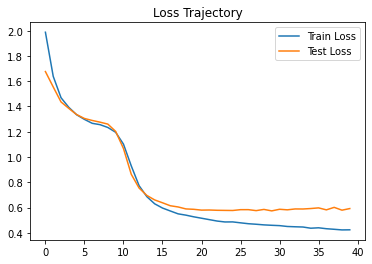

In [18]:
# loss 시각화
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.title('Loss Trajectory')
plt.legend()
plt.show()

In [23]:
# 모델 예측 값 확인
y_test = np.argmax(y_test, axis=1) # true label
y_pred = model.predict([X_test_s, X_test_q])
y_pred = np.argmax(y_pred, axis=1) # pred label

# 랜덤하게 예측된 라벨과 정답 확인
NUM_DISPLAY = int(input('확인할 라벨 수 설정: '))
for i in random.sample(range(X_test_s.shape[0]), NUM_DISPLAY):
    story = " ".join([idx2word[x] for x in X_test_s[i].tolist() if x != 0])
    question = " ".join([idx2word[x] for x in X_test_q[i].tolist()])
    true_label = idx2word[y_test[i]]
    pred_label = idx2word[y_pred[i]]
    print(story, question)
    print(f"    True label: {true_label}, Pred label: {pred_label}")
    print()

확인할 라벨 수 설정: 15
john went back to the hallway . john moved to the office . where is john ?
    True label: office, Pred label: office

john went to the hallway . mary moved to the kitchen . where is daniel ?
    True label: office, Pred label: garden

john travelled to the garden . mary went back to the office . where is mary ?
    True label: office, Pred label: office

daniel journeyed to the office . sandra moved to the bedroom . where is sandra ?
    True label: bedroom, Pred label: bedroom

mary journeyed to the kitchen . sandra went back to the garden . where is sandra ?
    True label: garden, Pred label: garden

sandra journeyed to the hallway . john went back to the garden . where is john ?
    True label: garden, Pred label: garden

mary moved to the kitchen . mary went back to the bathroom . where is mary ?
    True label: bathroom, Pred label: bathroom

john travelled to the kitchen . john went back to the bathroom . where is john ?
    True label: bathroom, Pred label: bat

In [ ]:
# 

# ============ 테스트 ============

In [3]:
with open(train_path, "r") as f:
    for line in f:
        print(line)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

7 Daniel travelled to the office.

8 Daniel went back to the bedroom.

9 Where is Sandra? 	bathroom	2

10 John journeyed to the kitchen.

11 Sandra went back to the kitchen.

12 Where is John? 	kitchen	10

13 Daniel journeyed to the bathroom.

14 Daniel went back to the garden.

15 Where is Sandra? 	kitchen	11

1 Sandra went back to the bedroom.

2 Sandra went to the garden.

3 Where is Sandra? 	garden	2

4 Daniel travelled to the bathroom.

5 Mary moved to the garden.

6 Where is Mary? 	garden	5

7 Mary went back to the bathroom.

8 John moved to the kitchen.

9 Where is John? 	kitchen	8

10 Mary went to the kitchen.

11 John travelled to the office.

12 Where is Mary? 	kitchen	10

13 Mary went to the bedroom.

14 Mary travelled to the bathroom.

15 Where is Mary? 	bathroom	14

1 Daniel went back to the bedroom.

2 Daniel travelled to the office.

3 Where is Daniel? 	office	2

4 Mary went back to the bathroom.

5 John went to the hallway.

6 Where 

In [5]:
with open(train_path, "r") as f:
    for line in f:
        print(line.split(" ", 1)) # 각 줄에서 공백 기준으로 한 번만 자른다. 앞의 number와 문장으로 분할.

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['12', 'Where is Sandra? \tgarden\t10\n']
['13', 'Mary journeyed to the bedroom.\n']
['14', 'Mary went to the bathroom.\n']
['15', 'Where is Mary? \tbathroom\t14\n']
['1', 'Daniel went back to the bedroom.\n']
['2', 'Sandra went back to the hallway.\n']
['3', 'Where is Daniel? \tbedroom\t1\n']
['4', 'Sandra moved to the bathroom.\n']
['5', 'Sandra journeyed to the bedroom.\n']
['6', 'Where is Sandra? \tbedroom\t5\n']
['7', 'Mary journeyed to the hallway.\n']
['8', 'Daniel went back to the office.\n']
['9', 'Where is Sandra? \tbedroom\t5\n']
['10', 'Mary moved to the bathroom.\n']
['11', 'Daniel went to the garden.\n']
['12', 'Where is Mary? \tbathroom\t10\n']
['13', 'Sandra moved to the office.\n']
['14', 'Sandra travelled to the hallway.\n']
['15', 'Where is Daniel? \tgarden\t11\n']
['1', 'Mary went back to the kitchen.\n']
['2', 'Mary journeyed to the office.\n']
['3', 'Where is Mary? \toffice\t2\n']
['4', 'Mary journeyed to the kitchen.\n']
['5', 

In [13]:
for stories, questions, answers in [train_data, test_data]:
    print(len(stories))

10000
1000


In [18]:
vocab_dict.most_common() # 튜플 형태로 되어 있다.

[('to', 22000),
 ('the', 22000),
 ('.', 22000),
 ('where', 11000),
 ('is', 11000),
 ('?', 11000),
 ('went', 8836),
 ('john', 8292),
 ('sandra', 8277),
 ('mary', 8221),
 ('daniel', 8210),
 ('bathroom', 5625),
 ('office', 5506),
 ('garden', 5498),
 ('hallway', 5473),
 ('kitchen', 5471),
 ('bedroom', 5427),
 ('journeyed', 4430),
 ('travelled', 4428),
 ('back', 4366),
 ('moved', 4306)]

In [21]:
word2idx

{'.': 3,
 '?': 6,
 'PAD': 0,
 'back': 20,
 'bathroom': 12,
 'bedroom': 17,
 'daniel': 11,
 'garden': 14,
 'hallway': 15,
 'is': 5,
 'john': 8,
 'journeyed': 18,
 'kitchen': 16,
 'mary': 10,
 'moved': 21,
 'office': 13,
 'sandra': 9,
 'the': 2,
 'to': 1,
 'travelled': 19,
 'went': 7,
 'where': 4}

In [26]:
idx2word

{0: 'PAD',
 1: 'to',
 2: 'the',
 3: '.',
 4: 'where',
 5: 'is',
 6: '?',
 7: 'went',
 8: 'john',
 9: 'sandra',
 10: 'mary',
 11: 'daniel',
 12: 'bathroom',
 13: 'office',
 14: 'garden',
 15: 'hallway',
 16: 'kitchen',
 17: 'bedroom',
 18: 'journeyed',
 19: 'travelled',
 20: 'back',
 21: 'moved'}

In [52]:
print(itertools.chain.from_iterable(['abcd', ['efgh', '3', 5, [1, 2]]])) # <itertools.chain object at 0x7ffb2a67f710>
list(itertools.chain.from_iterable(['abcd', ['efgh', '3', 5, [1, 2]]]))

['a', 'b', 'c', 'd', 'efgh', '3', 5, [1, 2]]